In [1]:
setwd("..")

In [2]:
source("Source/functions.R")

In [3]:
library("data.table")
library("Seurat")
library("clusterProfiler")
library("pheatmap")
library("dendextend")
library("RColorBrewer")
library("ggplot2")
library("patchwork")

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t


clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan,
X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal
enrichment tool for interpreting omics data. The Innovation. 2021,
2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter


---------------------
Welcome to dendextend version 1.17.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r a

In [4]:
SampleInfo <- fread("Data/SampleInfo.csv")

sampleIDs <- SampleInfo[, SampleID]
SampleInfo[, Type := factor(SampleInfo[, Type], levels = c("N", "S", "M", "T"))]
SampleInfo[, IsResponsive := factor(ifelse(SampleInfo[, Type] == "N", "N", "Y"), levels = c("N", "Y"))]

sampleGroups <- c("N", "S", "M", "T")

groupColors <- c(N = "#888888", 
                 S = rgb(red = 0, green = 128/255, blue = 225/255),
                 M = rgb(red = 255/255, green = 255/255, blue = 0), 
                 T = rgb(red = 255/255, green = 0, blue = 255/255)
)

sampleColors <- groupColors[SampleInfo[J(sampleIDs), as.character(Type), on = "SampleID"]]
names(sampleColors) <- sampleIDs

In [5]:
pairwise_cmps <- c("T_vs_S", "T_vs_M", "S_vs_M", "S_vs_N", "M_vs_N", "T_vs_N")

pairwise_siggenes_exon <- Tools$read_xlsx(file = "Result/pairwise_siggenes_exon.xlsx", sheet = pairwise_cmps)
pairwise_siggenes_exon <- lapply(pairwise_siggenes_exon, function(X) lapply(X, function(x) Tools$omit_space(x)))

In [6]:
pairwise_siggenes_R_vs_N <- Reduce(union, list(pairwise_siggenes_exon$T_vs_N$both, pairwise_siggenes_exon$S_vs_N$both, pairwise_siggenes_exon$M_vs_N$both))

In [7]:
str(pairwise_siggenes_R_vs_N)

 chr [1:963] "Socs4" "9330159F19Rik" "Reps2" "Mfsd9" "Prr5l" "Frem1" "Car9" ...


In [8]:
cnts_exon <- read.csv("Data/cnts_exon.csv.gz", row.names = 1, as.is = TRUE)

In [9]:
srt_exon <- CreateSeuratObject(cnts_exon, assay = "RNA", min.cells = 5, min.features = 200)
srt_exon <- NormalizeData(srt_exon, normalization.method = "LogNormalize", scale.factor = 1000000)
srt_exon <- FindVariableFeatures(srt_exon, assay = "RNA", selection.method = "vst", nfeatures = 2000)
srt_exon <- ScaleData(srt_exon, features = union(VariableFeatures(srt_exon), pairwise_siggenes_R_vs_N))
Idents(srt_exon) <- SampleInfo[, Type]
srt_exon <- RunPCA(srt_exon, assay = "RNA", features = pairwise_siggenes_R_vs_N, npcs = length(sampleIDs)-1)

Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”
Normalizing layer: counts
Finding variable features for layer counts
Centering and scaling data matrix
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  Rps20, Rpl24, Rps18, Hsp90ab1, Rac1, Mrpl52, Rpl37, Mir684-1, Cox7b, Eif4a1 
	   Brk1, Hsp90aa1, Gm12504, Ppig, Rpl17, Rpl36a, Nme2, Sh3bgrl3, Actr2, Slc25a47 
	   Eif5b, Snrpb2, Thap4, Polr1d, Cotl1, Fscn2, Sec61b, Dynlt3, Ndufb4, Mnat1 
Negative:  Igf2r, Trim39, Slc39a9, Tmem18, Cadm2, Prep, Pcnxl4, Man2a2, Asxl2, Sh3pxd2b 
	   Mtf2, Zfp938, Exoc1, Mms19, Slc16a1, Amotl1, Fzd6, Slc1a2, Tmem38b, 9530091C08Rik 
	   Otud4, Pag1, Dgkz, Cacnb2, Glt25d2, Zfp512, Smcr7, Herc1, Pip4k2b, Clcn7 
PC_ 2 
Positive:  Ppp2cb, Anp32e, Sgol2, Malsu1, Mto1, Gnptab, 2900011O08Rik, Rfc3, Tars, Ercc6l2 
	   Cdkn2d, Vapa, Trip13, Gabbr1, Tex30, Suv39h2, Golga3, 2

### Fig. 2A

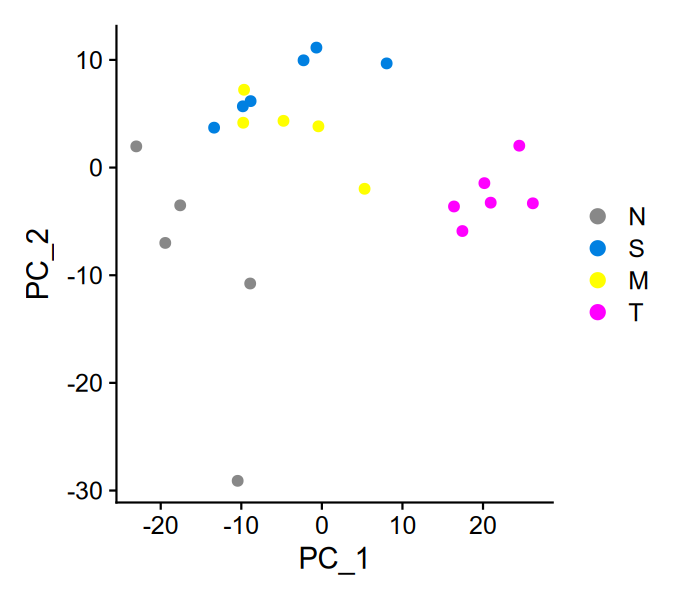

In [10]:
options(repr.plot.width = 4.5, repr.plot.height = 4, repr.plot.res = 150)
DimPlot(srt_exon, reduction = "pca", pt.size = 2, repel = TRUE, cols = groupColors)

In [11]:
srt_exon_exprs <- t(FetchData(srt_exon, vars = pairwise_siggenes_R_vs_N))

In [12]:
srt_exon_exprs_S_vs_N <- srt_exon_exprs[pairwise_siggenes_exon$S_vs_N$both, SampleInfo[Type %in% c("S", "N"), SampleID]]
srt_exon_exprs_T_vs_N <- srt_exon_exprs[pairwise_siggenes_exon$T_vs_N$both, SampleInfo[Type %in% c("T", "N"), SampleID]]
srt_exon_exprs_M_vs_N <- srt_exon_exprs[pairwise_siggenes_exon$M_vs_N$both, SampleInfo[Type %in% c("M", "N"), SampleID]]

In [13]:
heatmapbreaks <- seq(
    min(min(t(scale(t(srt_exon_exprs_S_vs_N)))), min(t(scale(t(srt_exon_exprs_T_vs_N)))), min(t(scale(t(srt_exon_exprs_M_vs_N))))) - 0.01,
    max(max(t(scale(t(srt_exon_exprs_S_vs_N)))), max(t(scale(t(srt_exon_exprs_T_vs_N)))), max(t(scale(t(srt_exon_exprs_M_vs_N))))) + 0.01, 
    length.out = 256)
heatmapcolors = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(heatmapbreaks))

### Fig. 2B (left)

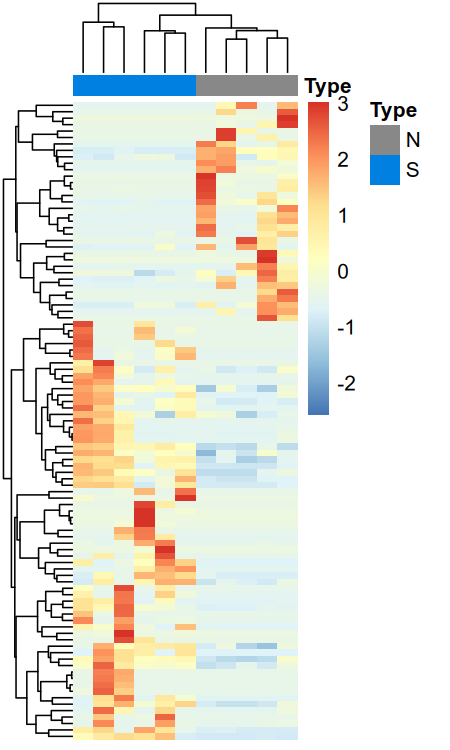

In [14]:
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 150)
pheatmap(
    srt_exon_exprs_S_vs_N, 
    annotation_col = SampleInfo[, data.frame(Type = Type, row.names = SampleID)], 
    show_rownames = FALSE, 
    angle = 90, 
    border = FALSE, 
    annotation_colors = list(Type = groupColors[c("N", "S")]), 
    scale = "row", 
    color = heatmapcolors, 
    breaks = heatmapbreaks, 
    show_colnames = FALSE, 
    treeheight_row = 30, 
    treeheight_col = 30
)

### Fig. 2B (middle)

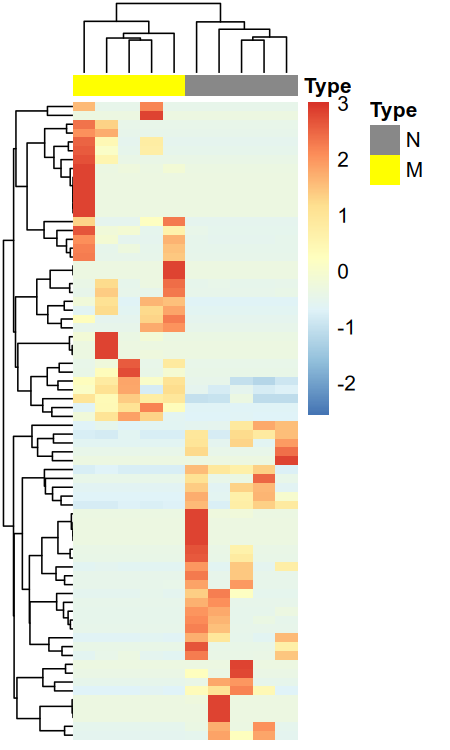

In [15]:
srt_exon_heatmap_M_vs_N <- rotate(
    hclust(dist(scale(t(srt_exon_exprs_M_vs_N)))), 
    order = colnames(srt_exon_exprs_M_vs_N)[order(SampleInfo[J(colnames(srt_exon_exprs_M_vs_N)), Type, on = "SampleID"], decreasing = TRUE)]
)

options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 150)
pheatmap(
    srt_exon_exprs_M_vs_N, 
    cluster_cols = srt_exon_heatmap_M_vs_N, 
    annotation_col = SampleInfo[, data.frame(Type = Type, row.names = SampleID)], 
    show_rownames = FALSE, 
    angle = 90, 
    border = FALSE, 
    annotation_colors = list(Type = groupColors[c("N", "M")]), 
    scale = "row", 
    color = heatmapcolors, 
    breaks = heatmapbreaks, 
    show_colnames = FALSE, 
    treeheight_row = 30, 
    treeheight_col = 30
)

### Fig. 2B (right)

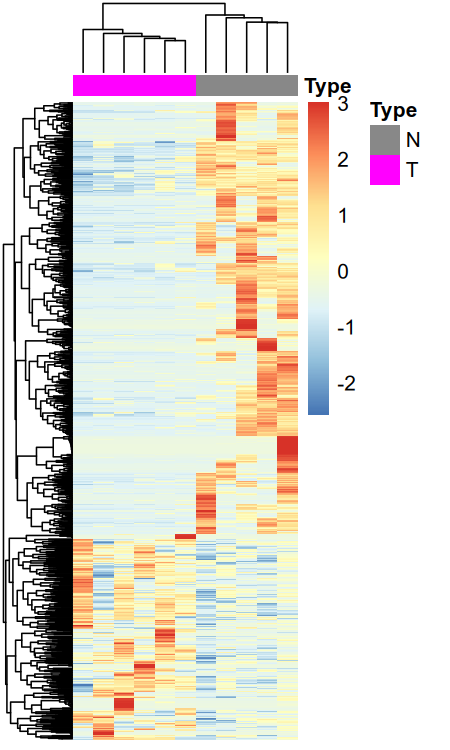

In [16]:
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 150)
pheatmap(
    srt_exon_exprs_T_vs_N, 
    annotation_col = SampleInfo[, data.frame(Type = Type, row.names = SampleID)], 
    show_rownames = FALSE, 
    angle = 90, 
    border = FALSE, 
    annotation_colors = list(Type = groupColors[c("N", "T")]), 
    scale = "row", 
    color = heatmapcolors, 
    breaks = heatmapbreaks, 
    show_colnames = FALSE, 
    treeheight_row = 30, 
    treeheight_col = 30
)

In [17]:
pairwise_exon_ego_S_vs_N_up <- Tools$read_xlsx("Result/pairwise_siggenes_exon_enrich_GO.xlsx", sheet = "S_vs_N_up")[[1]]
pairwise_exon_ego_S_vs_N_dn <- Tools$read_xlsx("Result/pairwise_siggenes_exon_enrich_GO.xlsx", sheet = "S_vs_N_dn")[[1]]
pairwise_exon_ego_M_vs_N_up <- Tools$read_xlsx("Result/pairwise_siggenes_exon_enrich_GO.xlsx", sheet = "M_vs_N_up")[[1]]
pairwise_exon_ego_M_vs_N_dn <- Tools$read_xlsx("Result/pairwise_siggenes_exon_enrich_GO.xlsx", sheet = "M_vs_N_dn")[[1]]
pairwise_exon_ego_T_vs_N_up <- Tools$read_xlsx("Result/pairwise_siggenes_exon_enrich_GO.xlsx", sheet = "T_vs_N_up")[[1]]
pairwise_exon_ego_T_vs_N_dn <- Tools$read_xlsx("Result/pairwise_siggenes_exon_enrich_GO.xlsx", sheet = "T_vs_N_dn")[[1]]

In [18]:
pairwise_exon_ego_S_vs_N_up$cmp <- "S_vs_N"
pairwise_exon_ego_S_vs_N_up$reg <- "up"
pairwise_exon_ego_S_vs_N_dn$cmp <- "S_vs_N"
pairwise_exon_ego_S_vs_N_dn$reg <- "dn"
pairwise_exon_ego_M_vs_N_up$cmp <- "M_vs_N"
pairwise_exon_ego_M_vs_N_up$reg <- "up"
pairwise_exon_ego_M_vs_N_dn$cmp <- "M_vs_N"
pairwise_exon_ego_M_vs_N_dn$reg <- "dn"
pairwise_exon_ego_T_vs_N_up$cmp <- "T_vs_N"
pairwise_exon_ego_T_vs_N_up$reg <- "up"
pairwise_exon_ego_T_vs_N_dn$cmp <- "T_vs_N"
pairwise_exon_ego_T_vs_N_dn$reg <- "dn"

In [19]:
pairwise_exon_ego_up <- rbind(
    pairwise_exon_ego_S_vs_N_up, 
    pairwise_exon_ego_M_vs_N_up, 
    pairwise_exon_ego_T_vs_N_up
)
pairwise_exon_ego_dn <- rbind(
    pairwise_exon_ego_S_vs_N_dn, 
    pairwise_exon_ego_M_vs_N_dn, 
    pairwise_exon_ego_T_vs_N_dn
)

In [20]:
pairwise_exon_ego_up$log2ratio <- log2(sapply(pairwise_exon_ego_up$GeneRatio, function(x) 
    eval(parse(text=x)))) - log2(sapply(pairwise_exon_ego_up$BgRatio, function(x) eval(parse(text=x))))
pairwise_exon_ego_dn$log2ratio <- log2(sapply(pairwise_exon_ego_dn$GeneRatio, function(x) 
    eval(parse(text=x)))) - log2(sapply(pairwise_exon_ego_dn$BgRatio, function(x) eval(parse(text=x))))

In [21]:
pairwise_exon_ego_up_sig <- subset(pairwise_exon_ego_up, qvalue < 0.1)

terms_all <- unique(pairwise_exon_ego_up_sig[, "Description"]) 
terms_T_uniq <- setdiff(subset(pairwise_exon_ego_up_sig, cmp == "T_vs_N")[, "Description"], subset(pairwise_exon_ego_up_sig, cmp != "T_vs_N")[, "Description"])
terms_S_uniq <- setdiff(subset(pairwise_exon_ego_up_sig, cmp == "S_vs_N")[, "Description"], subset(pairwise_exon_ego_up_sig, cmp != "S_vs_N")[, "Description"])
terms_M_uniq <- setdiff(subset(pairwise_exon_ego_up_sig, cmp == "M_vs_N")[, "Description"], subset(pairwise_exon_ego_up_sig, cmp != "M_vs_N")[, "Description"])

terms_S_M_T_shared <- Reduce(
    intersect, 
    list(
        subset(pairwise_exon_ego_up_sig, cmp == "S_vs_N")[, "Description"], 
        subset(pairwise_exon_ego_up_sig, cmp == "M_vs_N")[, "Description"], 
        subset(pairwise_exon_ego_up_sig, cmp == "T_vs_N")[, "Description"]
    )
)

terms_S_M_shared <- setdiff(intersect(subset(pairwise_exon_ego_up_sig, cmp == "S_vs_N")[, "Description"], subset(pairwise_exon_ego_up_sig, cmp == "M_vs_N")[, "Description"]), terms_S_M_T_shared)
terms_S_T_shared <- setdiff(intersect(subset(pairwise_exon_ego_up_sig, cmp == "S_vs_N")[, "Description"], subset(pairwise_exon_ego_up_sig, cmp == "T_vs_N")[, "Description"]), terms_S_M_T_shared)
terms_M_T_shared <- setdiff(intersect(subset(pairwise_exon_ego_up_sig, cmp == "M_vs_N")[, "Description"], subset(pairwise_exon_ego_up_sig, cmp == "T_vs_N")[, "Description"]), terms_S_M_T_shared)

### Fig. 1E (top)

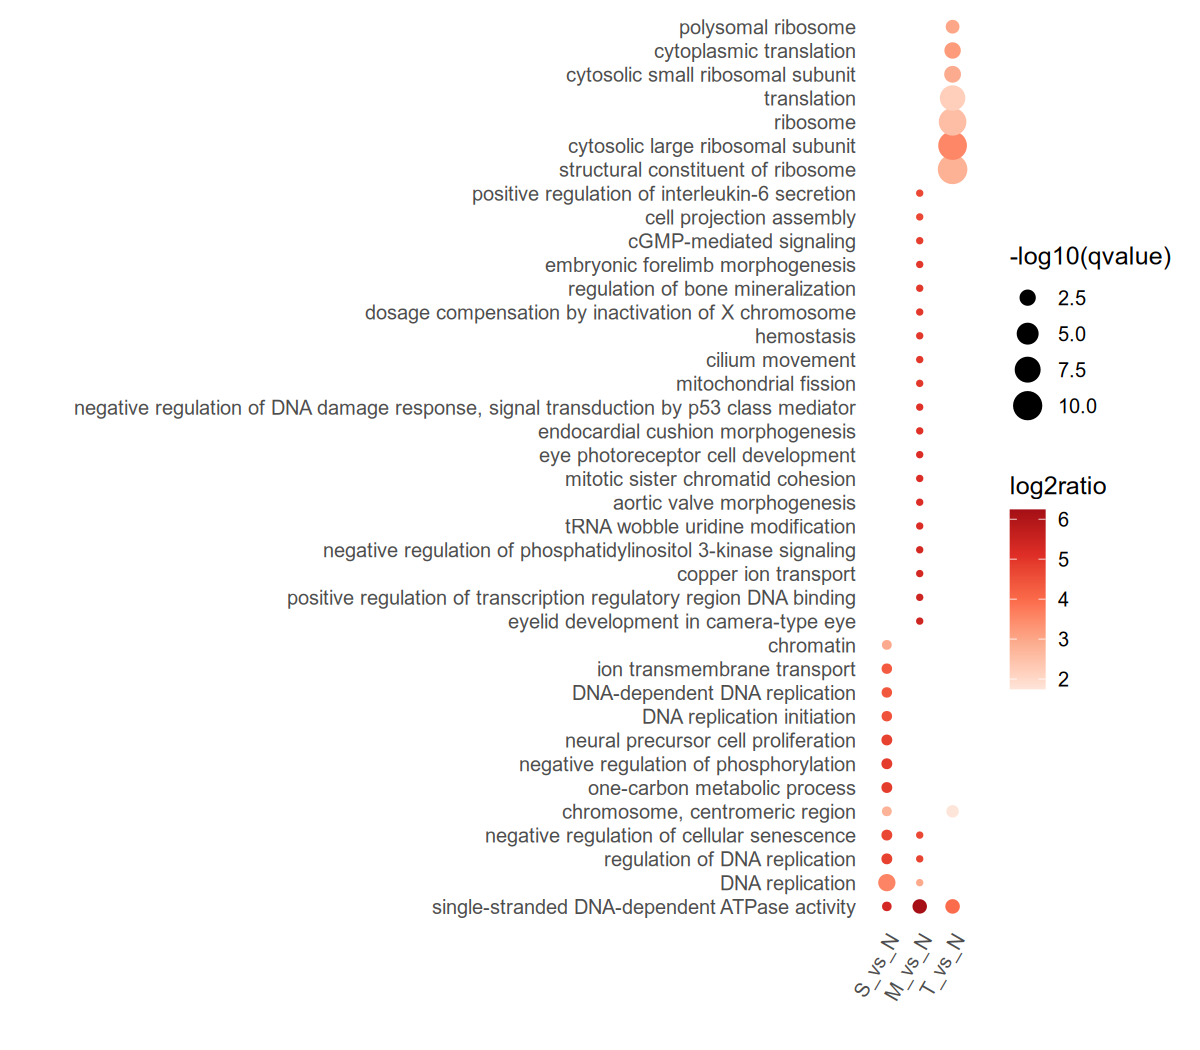

In [22]:
options(repr.plot.width = 8, repr.plot.height = 7, repr.plot.res = 150)
ggplot(pairwise_exon_ego_up_sig, aes(y = Description, x = cmp)) + 
    theme_classic(base_size = 12) + 
    theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust = 1), axis.line = element_blank(), axis.ticks = element_blank()) + 
    geom_point(aes(size = -log10(qvalue), color = log2ratio)) + 
    scale_y_discrete(limit = c(terms_S_M_T_shared, terms_S_M_shared, terms_M_T_shared, terms_S_T_shared, terms_S_uniq, terms_M_uniq, terms_T_uniq)) + 
    scale_x_discrete(limits = c("S_vs_N", "M_vs_N", "T_vs_N")) + 
    xlab("") + ylab("") + 
    scale_colour_gradientn(colours = brewer.pal("Reds", n = 5))

In [23]:
pairwise_exon_ego_dn_sig <- subset(pairwise_exon_ego_dn, qvalue < 0.1)
terms_all <- unique(pairwise_exon_ego_dn_sig[, "Description"]) 
terms_T_uniq <- setdiff(subset(pairwise_exon_ego_dn_sig, cmp == "T_vs_N")[, "Description"], subset(pairwise_exon_ego_dn_sig, cmp != "T_vs_N")[, "Description"])
terms_S_uniq <- setdiff(subset(pairwise_exon_ego_dn_sig, cmp == "S_vs_N")[, "Description"], subset(pairwise_exon_ego_dn_sig, cmp != "S_vs_N")[, "Description"])
terms_M_uniq <- setdiff(subset(pairwise_exon_ego_dn_sig, cmp == "M_vs_N")[, "Description"], subset(pairwise_exon_ego_dn_sig, cmp != "M_vs_N")[, "Description"])

terms_S_M_T_shared <- Reduce(
    intersect, 
    list(
        subset(pairwise_exon_ego_dn_sig, cmp == "S_vs_N")[, "Description"], 
        subset(pairwise_exon_ego_dn_sig, cmp == "M_vs_N")[, "Description"], 
        subset(pairwise_exon_ego_dn_sig, cmp == "T_vs_N")[, "Description"]
    )
)

terms_S_M_shared <- setdiff(intersect(subset(pairwise_exon_ego_dn_sig, cmp == "S_vs_N")[, "Description"], subset(pairwise_exon_ego_dn_sig, cmp == "M_vs_N")[, "Description"]), terms_S_M_T_shared)
terms_S_T_shared <- setdiff(intersect(subset(pairwise_exon_ego_dn_sig, cmp == "S_vs_N")[, "Description"], subset(pairwise_exon_ego_dn_sig, cmp == "T_vs_N")[, "Description"]), terms_S_M_T_shared)
terms_M_T_shared <- setdiff(intersect(subset(pairwise_exon_ego_dn_sig, cmp == "M_vs_N")[, "Description"], subset(pairwise_exon_ego_dn_sig, cmp == "T_vs_N")[, "Description"]), terms_S_M_T_shared)

### Fig. 1E (bottom)

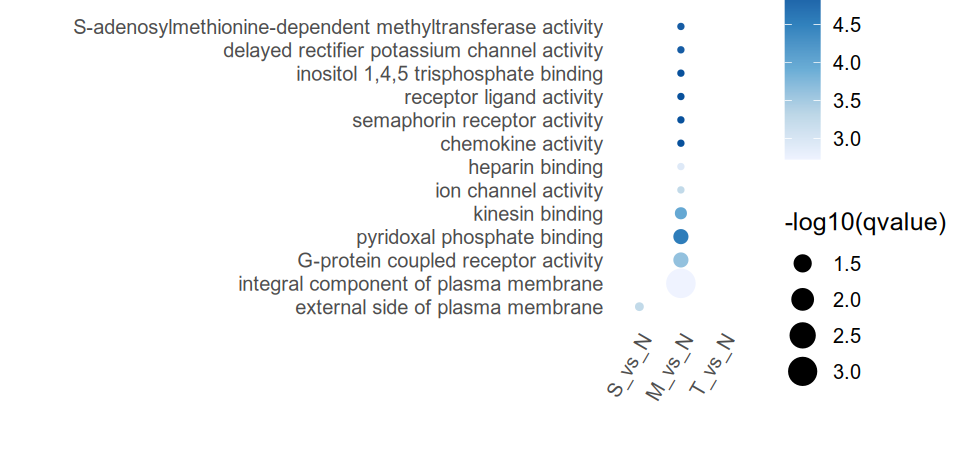

In [24]:
options(repr.plot.width = 6.5, repr.plot.height = 3, repr.plot.res = 150)
ggplot(pairwise_exon_ego_dn_sig, aes(y = Description, x = cmp)) + 
    theme_classic(base_size = 12) + 
    theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust = 1), axis.line = element_blank(), axis.ticks = element_blank()) + 
    geom_point(aes(size = -log10(qvalue), color = log2ratio)) + 
    scale_y_discrete(limit = c(terms_S_M_T_shared, terms_S_M_shared, terms_M_T_shared, terms_S_T_shared, terms_S_uniq, terms_M_uniq, terms_T_uniq)) + 
    scale_x_discrete(limits = c("S_vs_N", "M_vs_N", "T_vs_N")) + 
    xlab("") + ylab("") + 
    scale_colour_gradientn(colours = brewer.pal("Blues", n = 5))

In [25]:
genesets <- read.csv("Data/genesets.csv", as.is = TRUE)
genesets <- lapply(genesets, function(x) unique(Tools$omit_space(x)))

In [26]:
str(genesets)

List of 9
 $ Inflammation: chr [1:54] "Il17d" "Cish" "Cmtm8" "Tril" ...
 $ Mitochondria: chr [1:45] "Cox6c" "Atp5f1" "Cox7b" "Sdhc" ...
 $ Calcium     : chr [1:47] "Tmem110" "Vamp2" "Homer1" "Bzrap1" ...
 $ Epigenetic  : chr [1:52] "Paf1" "Zeb1" "Larp7" "Hmgn3" ...
 $ infl        : chr [1:16] "Cish" "G6pdx" "Hmgb1" "Scamp5" ...
 $ mito        : chr [1:38] "Aldh2" "NA.1" "Slc25a47" "Sdhc" ...
 $ calc        : chr [1:11] "Vdac1" "NA.4" "Stim2" "Orai2" ...
 $ tf          : chr [1:19] "Zeb1" "Larp7" "Atf5" "Supt5" ...
 $ chromatin   : chr [1:26] "Paf1" "Wiz" "Yaf2" "Cbx5" ...


In [27]:
exprs_exon <- read.csv("Result/exprs_exon.csv.gz", row.names = 1, as.is = TRUE)

### Fig. 4A (column 1)

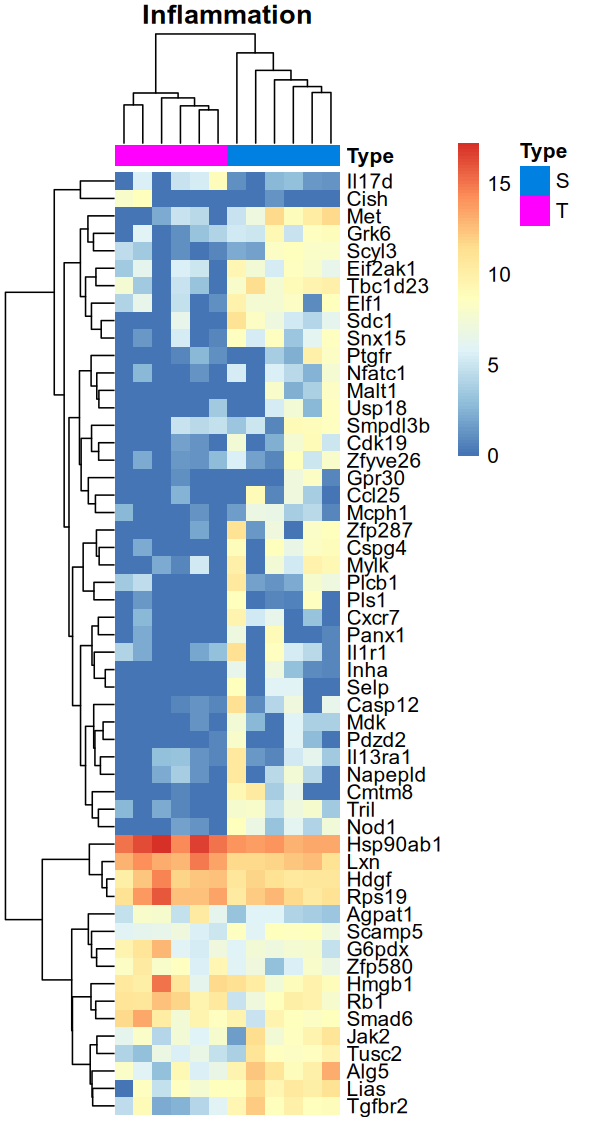

In [28]:
options(repr.plot.width = 4, repr.plot.height = 7.5, repr.plot.res = 150)
pheatmap(exprs_exon[genesets[["Inflammation"]], SampleInfo[!Type %in% c("M", "N"), SampleID]], 
    cluster_cols = TRUE, 
    cluster_row = TRUE, 
    scale = "none", 
    annotation_colors = list(Type = groupColors[!names(groupColors) %in% c("M", "N")]), 
    annotation_col = SampleInfo[, data.frame(Type = Type, row.names = SampleID)], 
    angle_col = 90, 
    show_rownames = TRUE, 
    show_colnames = FALSE, 
    borders = FALSE, 
    border_color = NA, 
    main = "Inflammation"
)

### Fig. 4A (column 2)

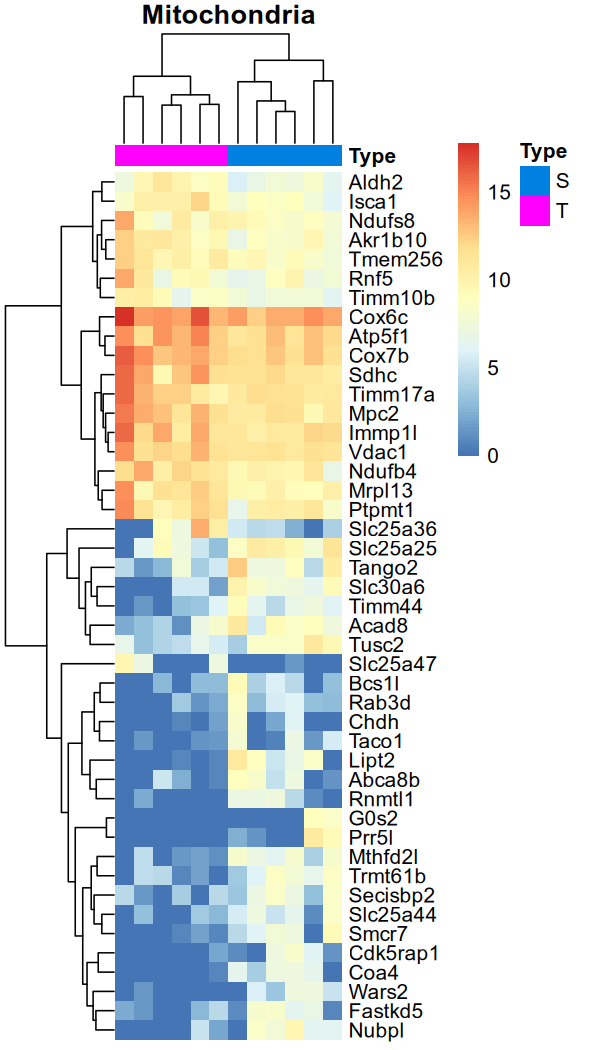

In [29]:
options(repr.plot.width = 4, repr.plot.height = 7, repr.plot.res = 150)
pheatmap(exprs_exon[genesets[["Mitochondria"]], SampleInfo[!Type %in% c("M", "N"), SampleID]], 
    cluster_cols = TRUE, 
    cluster_row = TRUE, 
    scale = "none", 
    annotation_colors = list(Type = groupColors[!names(groupColors) %in% c("M", "N")]), 
    annotation_col = SampleInfo[, data.frame(Type = Type, row.names = SampleID)], 
    angle_col = 90, 
    show_rownames = TRUE, 
    show_colnames = FALSE, 
    borders = FALSE, 
    border_color = NA, 
    main = "Mitochondria"
)

### Fig. 4A (column 3)

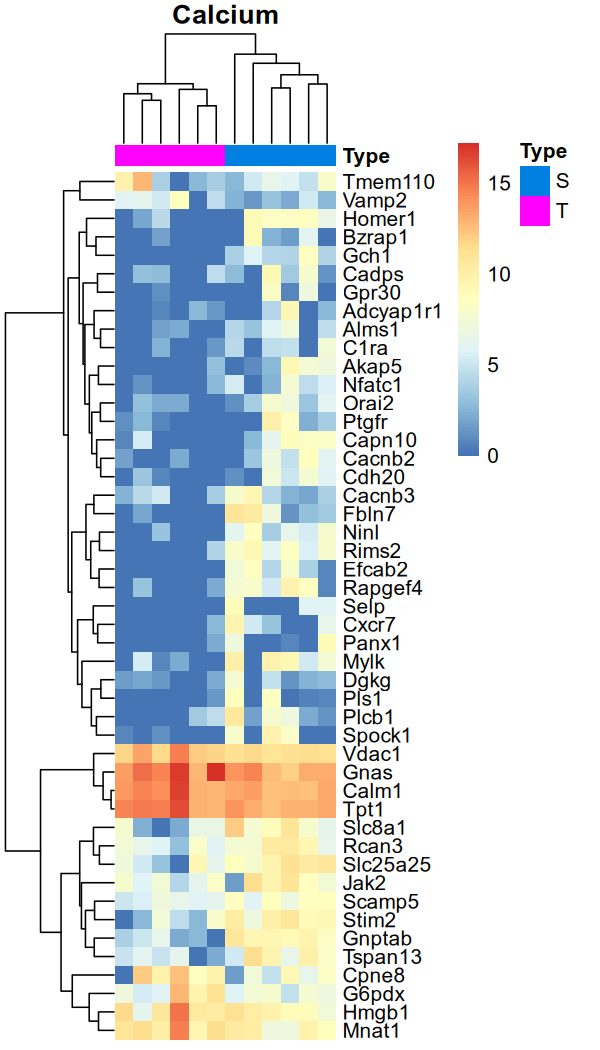

In [30]:
options(repr.plot.width = 4, repr.plot.height = 7, repr.plot.res = 150)
pheatmap(exprs_exon[genesets[["Calcium"]], SampleInfo[!Type %in% c("M", "N"), SampleID]], 
    cluster_cols = TRUE, 
    cluster_row = TRUE, 
    scale = "none", 
    annotation_colors = list(Type = groupColors[!names(groupColors) %in% c("M", "N")]), 
    annotation_col = SampleInfo[, data.frame(Type = Type, row.names = SampleID)], 
    angle_col = 90, 
    show_rownames = TRUE, 
    show_colnames = FALSE, 
    borders = FALSE, 
    border_color = NA, 
    main = "Calcium"
)

### Fig. 4A (column 4)

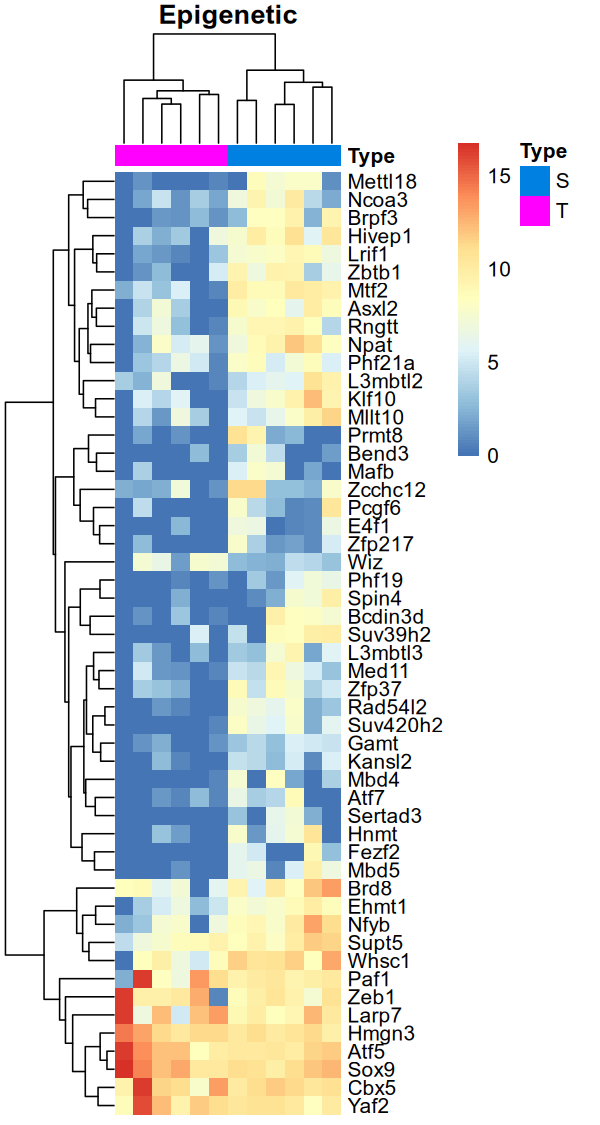

In [31]:
options(repr.plot.width = 4, repr.plot.height = 7.5, repr.plot.res = 150)
pheatmap(exprs_exon[genesets[["Epigenetic"]], SampleInfo[!Type %in% c("M", "N"), SampleID]], 
    cluster_cols = TRUE, 
    cluster_row = TRUE, 
    scale = "none", 
    annotation_colors = list(Type = groupColors[!names(groupColors) %in% c("M", "N")]), 
    annotation_col = SampleInfo[, data.frame(Type = Type, row.names = SampleID)], 
    angle_col = 90, 
    show_rownames = TRUE, 
    show_colnames = FALSE, 
    borders = FALSE, 
    border_color = NA, 
    main = "Epigenetic"
)

In [32]:
pairwise_DE_exon_T_vs_S <- Tools$read_xlsx("Result/pairwise_DE_tables_exon.xlsx", sheet = "T_vs_S")[[1]]

In [33]:
pairwise_DE_exon_S_vs_T_logfc <- -pairwise_DE_exon_T_vs_S[, "log2FoldChange"]
pairwise_DE_exon_S_vs_T_lfcse <- pairwise_DE_exon_T_vs_S[, "lfcSE"]
pairwise_DE_exon_S_vs_T_stats <- with(pairwise_DE_exon_T_vs_S, 
    data.table(
        Symbol = Symbol, 
        logfc = pairwise_DE_exon_S_vs_T_logfc, 
        lfcse = pairwise_DE_exon_S_vs_T_lfcse
    )
)

In [34]:
f11 <- ggplot(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$infl], aes(x = Symbol, y = logfc, fill = logfc > 0)) + 
    theme_classic(base_size = 12) + 
    theme(axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank()) + 
    geom_bar(stat = "identity") + 
    geom_errorbar(aes(ymin = logfc, ymax = ifelse(logfc > 0, logfc + lfcse, logfc - lfcse)), width = 0.5) + 
    scale_x_discrete(limits = pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$infl][order(logfc), Symbol]) + 
    scale_y_continuous(limits = c(-13, 13)) + 
    scale_fill_manual(values = c("TRUE" = unname(groupColors["S"]), "FALSE" = unname(groupColors["T"]))) + 
    annotate(
        geom = "text", 
        x = seq_along(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$infl][order(logfc), Symbol]), 
        y = ifelse(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$infl][order(logfc), logfc] > 0, -0.2, +0.2), 
        label = pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$infl][order(logfc), Symbol], 
        angle = 90, 
        hjust = ifelse(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$infl][order(logfc), logfc] > 0, 1, 0)
    ) + 
    xlab("") + 
    ylab("Log2 fold change (S:T)") + 
    guides(fill = "none") + 
    ggtitle("Inflammation and\nregulation of calcium")

In [35]:
f12 <- ggplot(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$mito], aes(x = Symbol, y = logfc, fill = logfc > 0)) + 
    theme_classic(base_size = 12) + 
    theme(axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank()) + 
    geom_bar(stat = "identity") + 
    geom_errorbar(aes(ymin = logfc, ymax = ifelse(logfc > 0, logfc + lfcse, logfc - lfcse)), width = 0.5) + 
    scale_x_discrete(limits = genesets$mito) + 
    scale_y_continuous(limits = c(-13, 13)) + 
    scale_fill_manual(values = c("TRUE" = unname(groupColors["S"]), "FALSE" = unname(groupColors["T"]))) + 
    annotate(
        geom = "text", 
        x = seq_along(genesets$mito), 
        y = ifelse(pairwise_DE_exon_S_vs_T_stats[genesets$mito, logfc, on = "Symbol"] > 0, -0.2, +0.2), 
        label = genesets$mito, 
        angle = 90, 
        hjust = ifelse(pairwise_DE_exon_S_vs_T_stats[genesets$mito, logfc, on = "Symbol"] > 0, 1, 0)
    ) + 
    xlab("") + 
    ylab("Log2 fold change (S:T)") + 
    guides(fill = "none") + 
    ggtitle("Mitochondrial")

In [36]:
f13 <- ggplot(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$calc], aes(x = Symbol, y = logfc, fill = logfc > 0)) + 
    theme_classic(base_size = 12) + 
    theme(axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank()) + 
    geom_bar(stat = "identity") + 
    geom_errorbar(aes(ymin = logfc, ymax = ifelse(logfc > 0, logfc + lfcse, logfc - lfcse)), width = 0.5) + 
    scale_x_discrete(limits = genesets$calc) + 
    scale_y_continuous(limits = c(-13, 13)) + 
    scale_fill_manual(values = c("TRUE" = unname(groupColors["S"]), "FALSE" = unname(groupColors["T"]))) + 
    annotate(
        geom = "text", 
        x = seq_along(genesets$calc), 
        y = ifelse(pairwise_DE_exon_S_vs_T_stats[genesets$calc, logfc, on = "Symbol"] > 0, -0.2, +0.2), 
        label = genesets$calc, 
        angle = 90, 
        hjust = ifelse(pairwise_DE_exon_S_vs_T_stats[genesets$calc, logfc, on = "Symbol"] > 0, 1, 0)
    ) + 
    xlab("") + 
    ylab("Log2 fold change (S:T)") + 
    guides(fill = "none") + 
    ggtitle("Calcium")

In [37]:
f21 <- ggplot(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$tf], aes(x = Symbol, y = logfc, fill = logfc > 0)) + 
    theme_classic(base_size = 12) + 
    theme(axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank()) + 
    geom_bar(stat = "identity") + 
    geom_errorbar(aes(ymin = logfc, ymax = ifelse(logfc > 0, logfc + lfcse, logfc - lfcse)), width = 0.5) + 
    scale_x_discrete(limits = pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$tf][order(logfc), Symbol]) + 
    scale_y_continuous(limits = c(-13, 13)) + 
    scale_fill_manual(values = c("TRUE" = unname(groupColors["S"]), "FALSE" = unname(groupColors["T"]))) + 
    annotate(
        geom = "text", 
        x = seq_along(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$tf][order(logfc), Symbol]), 
        y = ifelse(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$tf][order(logfc), logfc] > 0, -0.2, +0.2), 
        label = pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$tf][order(logfc), Symbol], 
        angle = 90, 
        hjust = ifelse(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$tf][order(logfc), logfc] > 0, 1, 0)
    ) + 
    xlab("") + 
    ylab("Log2 fold change (S:T)") + 
    guides(fill = "none") +
    ggtitle("Transcription regulators")

In [38]:
f22 <- ggplot(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$chromatin], aes(x = Symbol, y = logfc, fill = logfc > 0)) + 
    theme_classic(base_size = 12) + 
    theme(axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank()) + 
    geom_bar(stat = "identity") + 
    geom_errorbar(aes(ymin = logfc, ymax = ifelse(logfc > 0, logfc + lfcse, logfc - lfcse)), width = 0.5) + 
    scale_x_discrete(limits = pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$chromatin][order(logfc), Symbol]) + 
    scale_y_continuous(limits = c(-13, 13)) + 
    scale_fill_manual(values = c("TRUE" = unname(groupColors["S"]), "FALSE" = unname(groupColors["T"]))) + 
    annotate(
        geom = "text", 
        x = seq_along(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$chromatin][order(logfc), Symbol]), 
        y = ifelse(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$chromatin][order(logfc), logfc] > 0, -0.2, +0.2), 
        label = pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$chromatin][order(logfc), Symbol], 
        angle = 90, 
        hjust = ifelse(pairwise_DE_exon_S_vs_T_stats[Symbol %in% genesets$chromatin][order(logfc), logfc] > 0, 1, 0)
    ) + 
    xlab("") + 
    ylab("Log2 fold change (S:T)") + 
    guides(fill = "none") +
    ggtitle("Chromatin Remodelers")

### Fig. 4B

Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”


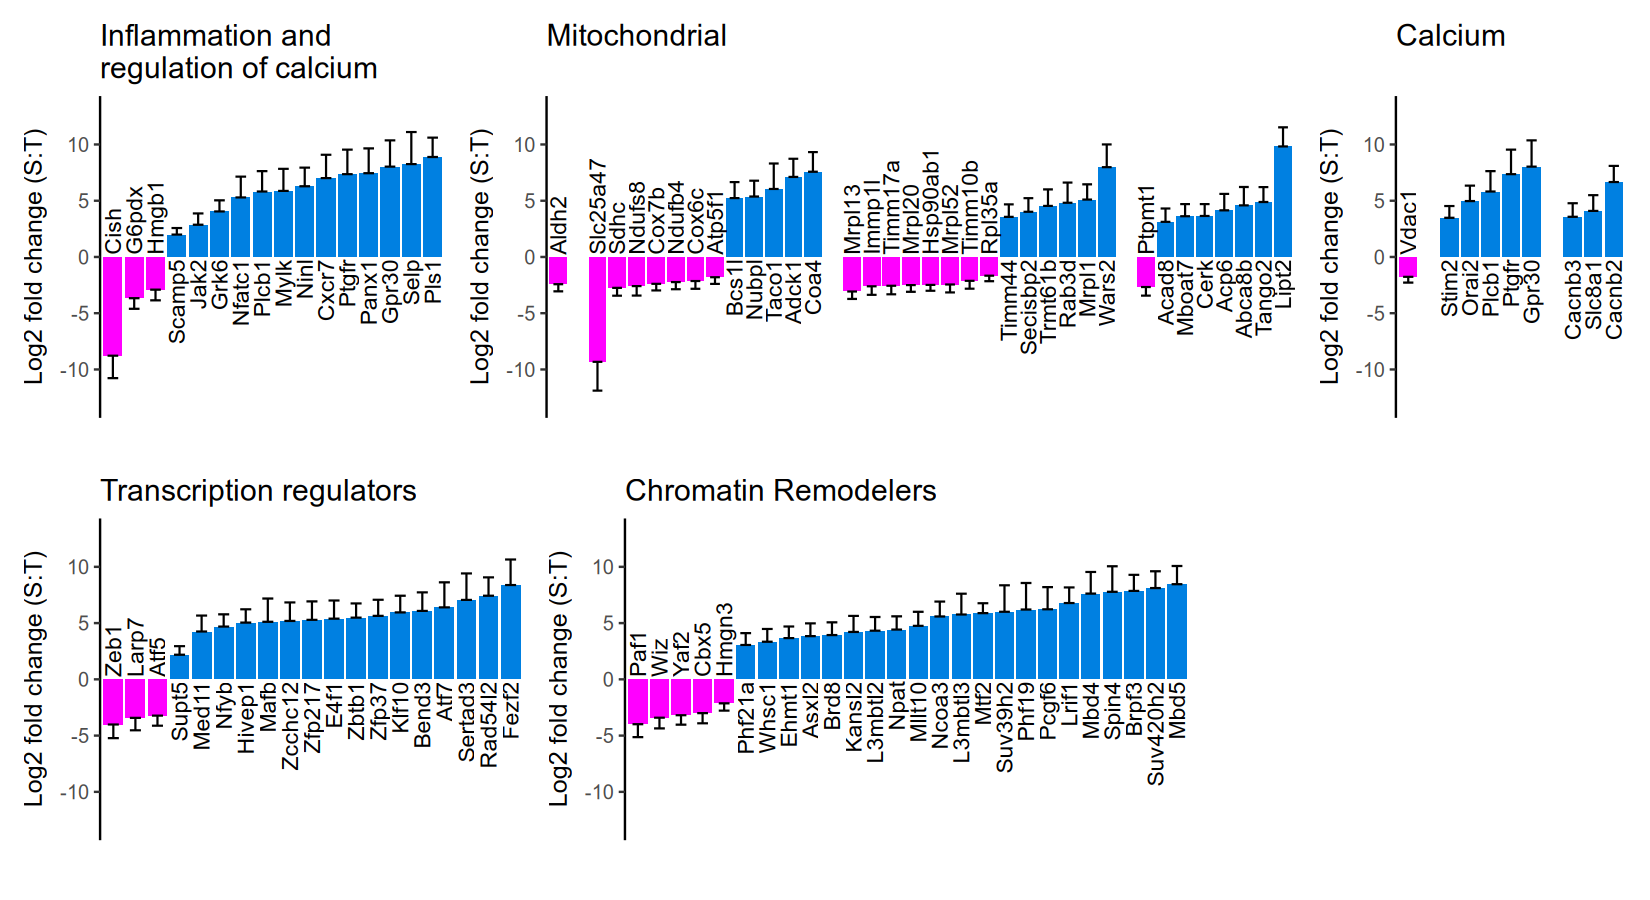

In [39]:
options(repr.plot.width = 11, repr.plot.height = 6, repr.plot.res = 150)
(f11 + f12 + f13 + plot_layout(widths = c(3, 6.5, 2))) / (f21 + f22 + plot_layout(widths = c(3, 4, 3)))

In [40]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.3.0        ggplot2_3.5.1          RColorBrewer_1.1-3    
 [4] dendextend_1.17.1      pheatmap_1.0.12        clusterProfiler_4.12.6
 [7] Seurat_5.1.0         